# *TOY FITTER tutorial*

# In a nutshell:  Neymann construction with likelihood ratio

## Some definitions:
- **mu** is our parameter of interest, the signal strenght, it can be considered as equal to the number of signal events. Altough there is a small difference (out of the scope of this tutorial).
- **q_mu** is the test statistic, the likelihood ratio. This is a function of the "tested" value of **mu**.
- **H_mu** is the signal hypothesis with a signal strenght **mu**.
- **H_0** is the null hypothesis, background only.

## General Idea
Porduce limits with the Neymann construction method. Typically this means that one wants to reject the signal hypothesis **H_mu**  in favour of the null, **H_0**. The whole game is then to find the value of **mu** for which the **H_mu** is rejected at 90% CL. To do so one needs the distibution of the test statistic **q_{mu}** under signal hypothesis **H_mu** (assuming that **H_mu** is true).
The whole procedure is quite involved, but can be divided in a few points:

**Produce the 90% quantiles curve** 
- Produce several MC toy datasets related to a specific hypothesis **mu**.
- **Fit** those datastes, meaning, compute the **q_mu**, testing the same exact **mu** for under which the toys are generated
- Now you have many **q_mu** values for a given **mu** test and the related hypothesis. So you have the distro of **q_mu** under the hypothesis **H_mu**. So you can compute the 90% quantile of that distribution **q_mu_90**, or in other words the value of **q_mu** that correspond to a p-value of 10%.
- Now you can repeat the procedure for a prefixed set of values of **mu** and obtain a set of **q_mu_90** points.
- Interpolate the latter set of points and you'll have a curve describing the evolution of the 90% quantile of the test statistic **q_mu_90** as a function of the tested value of **mu**.
- Now you can use that curve to compute the limits.

**Compute the limits or the sensitivity**
- Given a dataset, that can be real data (for real limit) or toy bkg only data (for sensitivity), one compute the value of **q_mu** for a given **mu**.
- Check that value againts the **q_mu_90** curve to find if its p-value is larger than 10%, if yes that **mu** hypothesis is excluded.
- Find the value of **mu** for which the likelihood ratio curve **q_mu** intersect the **q_mu_90** curve, that is the limit at 90% CL.
- If you are computing the real limmit then you are done, if you are computing sensitivity then repeat these last 2 points for many toy datasets untill you'll get the distribution of limits under the **H_0**. Find the median and 1-2sigma of that distro.

# 1) The focus of this tutorial:

If you came here first, you probably want to start from the tutorial on [generation of toys](https://github.com/XENON1T/Xephyr/blob/master/notebooks/ToyGenerator_example.ipynb) instead. 

We want to produce the "alternate hypothesis" test statistic distributions: **f(q_mu | H_mu)**, where: 
- mu is the parameter of interest
- q_mu is the test statistic coputed for a value mu_test
So that reads: the distro of the test statistic for mu_test = mu_true given that the true hipothesis for mu is mu = mu_true (so given data distributed with mu = mu_true).

We compute  f(q_mu | H_mu) for many mu_test = mu_true values and extract their 90% quantile.

We compute a TGraph of those quantile that we can evaluate at each point.

To get the sensitivity we compute the limit of a set of toys for the hypothesis H_0 (no signal). This means we find for each of them the value of mu_test that gives **q_mu_H0 = 90_quantile( f(q_mu-test | H_mu-test) )**


## 2) The Setup:
First of all I suggest you to produce a single compilable macro that contains the likelihood you want to use, you can find in other tutorial how to define the likelihood [here](https://xenon1t.github.io/Xephyr/docs/tutorials.html). The idea of this macro is to define a function that you can use to retrieve the likelihood, so that you have it defined in one place only. You can get inspiration on how to write this function from [here](https://github.com/XENON1T/Xephyr/blob/master/examples/SR1Like/src/likelihoodDef.cxx).

This tutorial depends on the Models of SR1 repository and on the likelihood definition and data stored in a xephyr example,  so you need to download the SR1 repository **WARNING::Huge file!**.

```bash
cd XEPHYR_DIR
git clone git@github.com:XENON1T/SR1Results.git SR1  # SR1 official repository

source Xephyr/pacman/installExample.sh  SR1Like      # Install Xephyr example in local dir
```

In [1]:
.x ../loadXephyr.C



      =================== Welcome to Xephyr =====================
       Version 6.0 dated 10-Oct-2017, compiled with ROOT 6.14/00

(int) 0


In [2]:
 TString xeDir(gSystem->Getenv("XEPHYR_DIR"));   // Xephyr work Directory 

In [3]:
// add path to include files to ROOT (in the file I'm going to load there are some Xephyr includes) 
gInterpreter->AddIncludePath(xeDir + "Xephyr/src");  // in this case is just XEPHYR src from next dir.

###### now load the function to retrieve the likelihood

In [4]:
gROOT->ProcessLine(".L  " + xeDir +"xephyr_examples/SR1Like/src/likelihoodDef.cxx");

In [5]:
double mass = 50.; // GeV
int likelihood_type = 0;  // [0=inner egg, 1= U volume, 2 = Wall volume]
TString collection_name = "test_mu5_V0_Gen1";   // remember? this is the name of the toy collection we generated

// The whole SR1 likelihood definition now is in this object here
// There is a notebook about how to build the likelihood, check it out.
// IMPORTANT NOTE:   /!\ this function call is different from the previous tutorial
// this will load the likelihood with data in it and already initialized
pdfLikelihood *likeHood =  getTheLikelihoodToFit( xeDir, collection_name , mass, likelihood_type);
// pdfLikelihood* getTheLikelihoodToFit(TString dir, TString name_of_file, double mass, int type, double other)


pdfComponent::Constructor - INFO : Reading file /home/pan/work/XEPHYR/SR1/StatisticalAnalyses/inputs_for_likelihood/lax_1.5.1_egg/sliced_2d_templates/ERBackgroundModel_Stitched_SR1_RunSourceCombinedFit180420.root
pdfComponent::Constructor - INFO : Reading file /home/pan/work/XEPHYR/SR1/StatisticalAnalyses/inputs_for_likelihood/lax_1.5.1_egg/sliced_2d_templates/Background_wall_ac_templates_v6_inegg_bin_SR1_2018-04-30.root
pdfComponent::Constructor - INFO : Reading file /home/pan/work/XEPHYR/SR1/StatisticalAnalyses/inputs_for_likelihood/lax_1.5.1_egg/sliced_2d_templates/Background_wall_ac_templates_v6_inegg_bin_SR1_2018-04-30.root
pdfComponent::Constructor - INFO : Reading file /home/pan/work/XEPHYR/SR1/StatisticalAnalyses/inputs_for_likelihood/lax_1.5.1_egg/sliced_2d_templates/RadiogenicNRBackgroundModel_SR1_RunSourceCombined180420.root
pdfComponent::Constructor - INFO : Reading file /home/pan/work/XEPHYR/SR1/StatisticalAnalyses/inputs_for_likelihood/lax_1.5.1_egg/sliced_2d_templates/Ra

In [6]:
ToyFitterExclusion fitter(collection_name);

In [7]:
fitter.setTheLikelihood(likeHood);

In [8]:
fitter.setSeed( 123 ) ;   // always remember to change the seed per mass, Generation. 

In [9]:
double mu_test = 0.5;   // we are now testing the signal hypothesis of 0.5 events (but data are generated with average 5)
double qstat = fitter.computeTS( mu_test );  // computing the test statistic with preset value of data in the likelihood

// the line above will first maximize the likelihood and then compute the likelihood (conditional FIT) for mu = 0.5

Finding maximum of L_SR1_V0
Total of 11 active parameters, don't freeze parameters of interest, Minuit fits 11 param.
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Of interest        0                 
  1 CNNSscale0           Nuisance           0                 
  2 RadioscaleNX0        Nuisance           0                 
  3 Radioscale0          Nuisance           0                 
  4 ACscale0             Nuisance           0                 
  5 Wallscale0           Nuisance           0                 
  6 ERscale0             Free               0                 
  7 _py0_                Free               0                 
  8 _rf0_                Free               0                 
  9 SignalScale0         Nuisance           0                 
 10 L_SR1_V0_SG          Free               1                 
ML -132094 achieved for 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigm

Info in <Minuit2>: Minuit2Minimizer::Minimize : Minimization did NOT converge, Edm is above max


ML -132095 achieved for 
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen           0.5                 
  1 CNNSscale0           Nuisance     -0.0073 +- 1.3      
  2 RadioscaleNX0        Nuisance      0.0055 +- 1.3      
  3 Radioscale0          Nuisance       0.078 +- 1.3      
  4 ACscale0             Nuisance      -0.044 +- 1.3      
  5 Wallscale0           Nuisance       -0.25 +- 1.2      
  6 ERscale0             Free            0.17 +- 0.093    
  7 _py0_                Free           0.092 +- 0.045    
  8 _rf0_                Free             1.9 +- 0.24     
  9 SignalScale0         Nuisance       0.011 +- 1.4      
 10 L_SR1_V0_SG          Free            0.14 +- 0.5      
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Frozen           0.5                 
  1 CNNSscale0           Nuisance     -0.0073                 
  2 RadioscaleNX0        Nuisance      0

Info in <Minuit2>: Minuit2Minimizer::Minimize : Minimization did NOT converge, Edm is above max


In [10]:
cout << "th value of the test statistic for the test hypothesis mu = 0.5 on the toy data with index 0 is: " << qstat << endl;

th value of the test statistic for the test hypothesis mu = 0.5 on the toy data with index 0 is: 1.45191


In [11]:
fitter.setPrintLevel(WARNING);   //  suppressing output to only WARNING (other possibilities are INFO, ERROR, DEBUG)

## 3) Fitting
### Fitting the Toy Generated Ntuple Tree list

Ok, let's recap a bit what was done above:
- We defined a likelihood that load the toy data generated (have a look at [this tutorial](...) )
- We fed this likelihood to a toy Fitter, this is just a class that helps with fitting the likelihood, meaning fixing the parameter of interest to some value and fitting the rest of the parameters (conditional fit)
- We then computed the lkelihood ratio value for a specific dataset and a specific value of the parameter of interest q(mu=0.5 | data)

Now, to produce the distribution of the test statistic q(mu | mu_true) for a given hypothesis mu_true we need to:
- produce many dataset under the hypotesis mu_true (we did this in [this tutorial](https://github.com/XENON1T/Xephyr/blob/master/notebooks/ToyGenerator_example.ipynb) )
- The hypothesis we choose was mu_true = 5
- Now we need to compute the test statistic value for all these datasets testing that same hypothesis mu_test = 5.
- Putting all the values togheter we have the expected distributions of the test statistc under hypothesis mu = 5.

Let's do it:

In [12]:
// some settings
fitter.setTreeName(collection_name);    // toy tree name prefix to fit in file (we already set that previosly, JUST TO SHOW)
fitter.setRandomizeMeasure(true);       // if randomize or not the nuissance parameter measure (default to true)
fitter.setOutputDir(xeDir) ;            // setting the dir where the output file is stored

fitter.setSeed( 123 ) ;   // always remember to change the seed per mass and Generation. 

likeHood->setPrintLevel(WARNING);  // to kill a bit of the output (remove this line if you want to see it)


In [13]:
int number_of_dataset_to_fit = 10;      // we fit only 10 datasets, otherwise is too long ;)
mu_test = 5. ;                   // in the generation of TS distributions mu_test must be equal to mu_true

// void fit(double mu, int stopAt=-999)
fitter.fit(mu_test, number_of_dataset_to_fit);   

dataHandler::setTreeIndex - DEBUG : setting new tree: test_mu5_V0_Gen1_0
dataHandler::setTreeIndex - DEBUG : setting new tree: test_mu5_V0_Gen1_Cal_0
dataHandler::setTreeIndex - DEBUG : setting new tree: test_mu5_V0_Gen1_1
dataHandler::setTreeIndex - DEBUG : setting new tree: test_mu5_V0_Gen1_Cal_1


Info in <Minuit2>: Minuit2Minimizer::Minimize : Minimization did NOT converge, Edm is above max
Info in <Minuit2>: Minuit2Minimizer::Minimize : Minimization did NOT converge, Edm is above max


dataHandler::setTreeIndex - DEBUG : setting new tree: test_mu5_V0_Gen1_2
dataHandler::setTreeIndex - DEBUG : setting new tree: test_mu5_V0_Gen1_Cal_2


Info in <Minuit2>: Minuit2Minimizer::Minimize : Minimization did NOT converge, Edm is above max
Info in <Minuit2>: Minuit2Minimizer::Minimize : Minimization did NOT converge, Edm is above max


dataHandler::setTreeIndex - DEBUG : setting new tree: test_mu5_V0_Gen1_3
dataHandler::setTreeIndex - DEBUG : setting new tree: test_mu5_V0_Gen1_Cal_3


Info in <Minuit2>: Minuit2Minimizer::Minimize : Minimization did NOT converge, Edm is above max
Info in <Minuit2>: MnGlobalCorrelationCoeff: inversion of matrix fails.
Info in <Minuit2>: Minuit2Minimizer::Minimize : Minimization did NOT converge, Edm is above max


dataHandler::setTreeIndex - DEBUG : setting new tree: test_mu5_V0_Gen1_4
dataHandler::setTreeIndex - DEBUG : setting new tree: test_mu5_V0_Gen1_Cal_4


Info in <Minuit2>: Minuit2Minimizer::Minimize : Minimization did NOT converge, Edm is above max
Info in <Minuit2>: Minuit2Minimizer::Minimize : Minimization did NOT converge, Edm is above max


dataHandler::setTreeIndex - DEBUG : setting new tree: test_mu5_V0_Gen1_5
dataHandler::setTreeIndex - DEBUG : setting new tree: test_mu5_V0_Gen1_Cal_5


Info in <Minuit2>: Minuit2Minimizer::Minimize : Minimization did NOT converge, Edm is above max
Info in <Minuit2>: Minuit2Minimizer::Minimize : Minimization did NOT converge, Edm is above max


dataHandler::setTreeIndex - DEBUG : setting new tree: test_mu5_V0_Gen1_6
dataHandler::setTreeIndex - DEBUG : setting new tree: test_mu5_V0_Gen1_Cal_6


Info in <Minuit2>: Minuit2Minimizer::Minimize : Minimization did NOT converge, Edm is above max
Info in <Minuit2>: Minuit2Minimizer::Minimize : Minimization did NOT converge, Edm is above max


dataHandler::setTreeIndex - DEBUG : setting new tree: test_mu5_V0_Gen1_7
dataHandler::setTreeIndex - DEBUG : setting new tree: test_mu5_V0_Gen1_Cal_7


Info in <Minuit2>: Minuit2Minimizer::Minimize : Minimization did NOT converge, Edm is above max


Stat::pdfLikelihood::computeTheLogLikelihood - WARNING : NsFs + NbFb < 0 
Stat::pdfLikelihood::computeTheLogLikelihood - WARNING : NsFs + NbFb < 0 


Info in <Minuit2>: Minuit2Minimizer::Minimize : Minimization did NOT converge, Edm is above max


dataHandler::setTreeIndex - DEBUG : setting new tree: test_mu5_V0_Gen1_8
dataHandler::setTreeIndex - DEBUG : setting new tree: test_mu5_V0_Gen1_Cal_8


Info in <Minuit2>: Minuit2Minimizer::Minimize : Minimization did NOT converge, Edm is above max


dataHandler::setTreeIndex - DEBUG : setting new tree: test_mu5_V0_Gen1_9
dataHandler::setTreeIndex - DEBUG : setting new tree: test_mu5_V0_Gen1_Cal_9


Info in <Minuit2>: Minuit2Minimizer::Minimize : Minimization did NOT converge, Edm is above max
Info in <Minuit2>: Minuit2Minimizer::Minimize : Minimization did NOT converge, Edm is above max


## 4) Having a look at output fit file
The line above produced a file in the previsly set "outDir" with prefix "post_fit_XXXX".
This contains a tree, the tree has an entry for each input Toy tree. Each entry contains the original parameter values with which the toy was generated, then the post fit values for nuissance parameters, likelihood and test statistic. 

In [6]:
TFile *fit_file = TFile::Open(xeDir + "post_fit_" + collection_name + ".root");
TTree *postFitTree  = (TTree*) fit_file->Get("post_fit_tree");

In [7]:
postFitTree->Print();

******************************************************************************
*Tree    :post_fit_tree: output tree for a given mu, hadd me                    *
*Entries :       10 : Total =           16297 bytes  File  Size =       6385 *
*        :          : Tree compression factor =   1.69                       *
******************************************************************************
*Br    0 :mu_fit    : mu_fit/D                                               *
*Entries :       10 : Total  Size=        659 bytes  File Size  =        115 *
*Baskets :        1 : Basket Size=      32000 bytes  Compression=   1.41     *
*............................................................................*
*Br    1 :mass      : mass/D                                                 *
*Entries :       10 : Total  Size=        649 bytes  File Size  =        113 *
*Baskets :        1 : Basket Size=      32000 bytes  Compression=   1.42     *
*................................................

As you can see there are only 10 entries, not so many to do any real statistical inference. I attached in the data folder a lighter version of the SR1 output from a similar script like above, so I can show some nice distro ;)

The file added below has been produced hadding several Fitter output files, for wimp mass=50GeV and computed for several hypothesis:

**mu_test = mu_true = { 0.5, 1, 2, 2.5, 3., 4. , 5., 10., 15}**. 

Maybe you noticed that the tree name in the file does not depend on anything, is always the same, this is crucial when hadding, so that one can send many jobs fitting many dataset in parallel (each with his corresponding GENERATION) and then **hadd** the output of all of them, obtaining a single tree with all the necessary information for almost any statistical study.

Let's have a look more in detail at what we can do with it:

In [8]:
// load the SR1 hadded output fit file
TFile *SR1_fit_file = TFile::Open(xeDir + "Xephyr/notebooks/data_examples/post_fit_apr_ER2_RG2_W2_M50_light.root");
TTree *SR1_postFitTree  = (TTree*) SR1_fit_file->Get("post_fit_tree");

#### We can now plot for example the distro of mu_hat for a certain value of Toy generated mu (true mu)
mu_hat is the first parameter of the unconditional fit

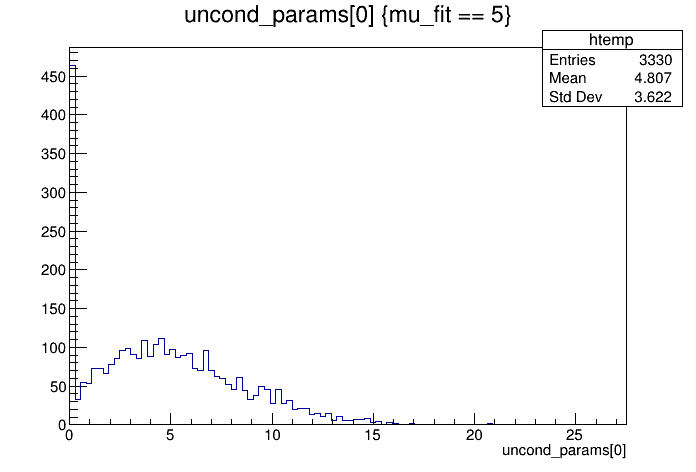

In [9]:
TCanvas *can = new TCanvas();
SR1_postFitTree->Draw("uncond_params[0]","mu_fit == 5");
can->Draw();

#### printout of all parameters

In [10]:
// true_params =  generated value of the parameter
// measured_params = extracted value of parametr at fitting time (to simulate a repetition of the experiment)
// uncond_params   = post fit value f the parameter UNCONDITIONAL = best fit overall (not fixing mu to a specific value)

// NOTE: Sigma here means mu.

SR1_postFitTree->Scan("name_params:true_params:measured_params:uncond_params","","", 1);

***********************************************************************
*    Row   * Instance * name_para * true_para * measured_ * uncond_pa *
***********************************************************************
*        0 *        0 *     Sigma *        10 *         0 * 12.434439 *
*        0 *        1 * CORR_RF_S *         0 *         0 * -0.733046 *
*        0 *        2 * CORR_PY_S *         0 *         0 * -0.053879 *
*        0 *        3 * CORR_ER_S *         0 *         0 * -0.006641 *
*        0 *        4 * CORR_CNNS *         0 * -0.288573 * -0.264157 *
*        0 *        5 * CORR_SIGN *         0 * -0.368677 * -0.370088 *
*        0 *        6 * Radioscal *         0 * 0.5974869 * 0.6004963 *
*        0 *        7 * Radioscal *         0 * 1.1416984 * 1.1658182 *
*        0 *        8 *  ACscale0 *         0 * 0.2935564 * 0.2789615 *
*        0 *        9 * Wallscale *         0 * 0.6215094 * 0.4230446 *
*        0 *       10 * L_SR1_V0_ *        10 *         1 * 1.00

### example of unconditional pulls for ER scale (parameter 3)

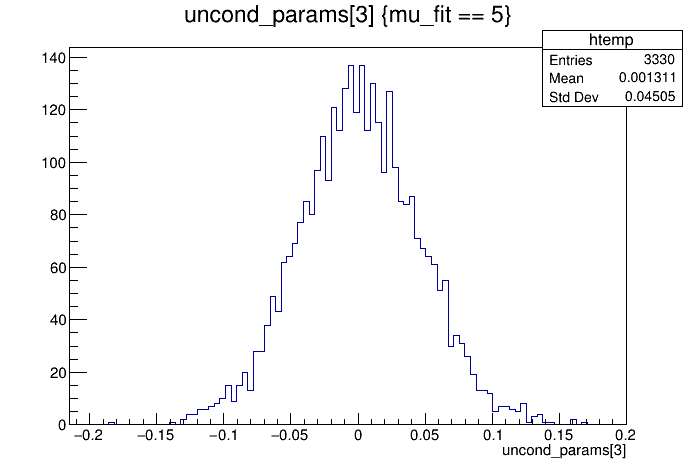

In [11]:
SR1_postFitTree->Draw("uncond_params[3]","mu_fit == 5");
can->Draw();

#### Or test statistic distributions

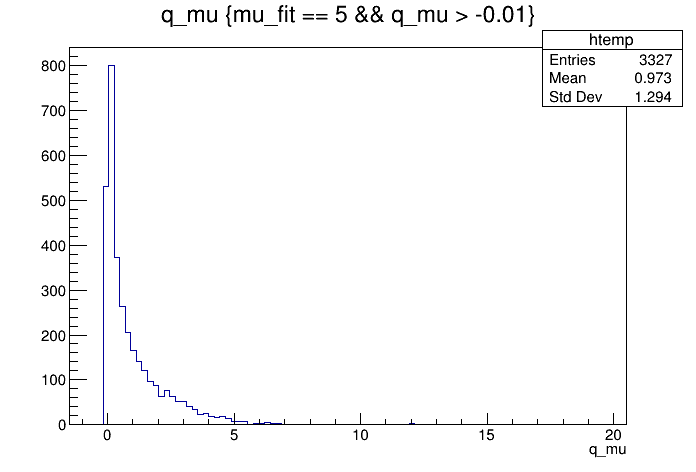

In [12]:
SR1_postFitTree->Draw("q_mu","mu_fit == 5 && q_mu > -0.01");  // sometimes has slightly negative value, seems a numerical issue
can->Draw();

## 4) Generating the 90% quantiles curve needed for limits

In [15]:
const int Nmu = 9;
double mu_lista[Nmu]   =  { 0.5, 1, 2, 2.5, 3., 4. , 5., 10., 15};    // list of true mu hypothesis that we fitted (tested)

        // giveTSquantiles ( TTree *tree, double *mu_list, int mu_size, TString OutDir, double wimpMass)

        TGraphAsymmErrors quantiles ( plotHelpers::giveTSquantiles( SR1_postFitTree,  mu_lista, Nmu, xeDir, mass ) );
    
    // This generate a file "ts_distros_quantiles_m50.root" in the XEPHYR_DIR with the 90% quantiles
    // also generates a PDF file with the distribution from which the quantiles are taken "quantiles_m50.pdf"



input_line_147:2:12: error: redefinition of 'Nmu'
 const int Nmu = 9;
           ^
input_line_143:2:12: note: previous definition is here
 const int Nmu = 9;
           ^


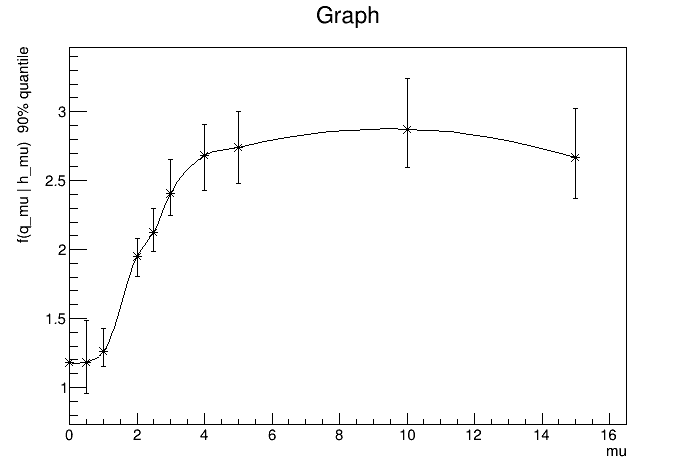

In [14]:
quantiles.GetXaxis()->SetTitle("mu");
quantiles.GetYaxis()->SetTitle("f(q_mu | h_mu)  90% quantile");
quantiles.Draw("AC*");
can->Draw();

### What do we do with it?
given a toy dataset generated under null hypothesis,  we compute q_mu for it, let's say for mu_test = 2.8, then mu = 2.8 is excluded @ >= 90% CL (given that dataset only) if the obtained q_mu >= 2.4

## 5) Limits and sensitivity bands

In [ ]:
// some settings
fitter.setInputDir("./");               // just to show how to change path to file (not needed), here we put same as constructor
fitter.setTreeName("null_hypo");         // toy tree name prefix to fit in file
fitter.setRandomizeMeasure(true);       // if randomize or not the nuissance parameter measure (default to true)

In [ ]:
// spitTheLimit(TGraphAsymmErrors *ninety_quantiles, int stopAt )
// :::WARNING::: this will take long time ;)
fitter.spitTheLimit(&quantiles, 10  );